In [1]:
import os
import sys
import logging
import tempfile
from datetime import timedelta
sys.path.append(os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath('.')))))

import torch
import torch.nn as nn
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data import DataLoader, DistributedSampler
import wandb

from src.depth_pro.network.encoder import DepthProEncoder
from src.depth_pro.network.decoder import MultiresConvDecoder
from src.depth_pro.training.dataset import DepthDataset
from src.depth_pro.training.losses import DepthLoss
from src.depth_pro import create_model_and_transforms
from src import depth_pro
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import torchvision.transforms as transforms

from transformers import AutoModelForImageSegmentation
from torchvision import transforms

import argparse

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

/home/badari/miniconda3/envs/depth-pro/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
birefnet = AutoModelForImageSegmentation.from_pretrained("ZhengPeng7/BiRefNet", trust_remote_code=True)
birefnet.to(device)

/home/badari/miniconda3/envs/depth-pro/lib/python3.9/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


BiRefNet(
  (bb): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=192, out_features=576, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=192, out_features=192, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=192, out_features=768, bias=T

In [3]:
# Pre-Trained Model Loading
model, model_transform = create_model_and_transforms(device=device, precision=torch.float32)

def_checkpoint = torch.load('/home/badari/Thesis_Depth/Analysis/ml-depth-pro/checkpoints/depth_pro.pt', map_location=device, weights_only=True)

def_model, _ = create_model_and_transforms(device=device, precision=torch.float32)

def_model.load_state_dict(def_checkpoint)

def_model.to(device)

def_model.eval()

INFO:src.depth_pro.network.vit_factory:Module(
  (model): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)

DepthPro(
  (encoder): DepthProEncoder(
    (patch_encoder): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): LayerScale()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linea

In [4]:
def load_checkpoint_for_inference(model_path: str, device: torch.device = 'cuda') -> tuple:
    """
    Load a checkpoint for inference, handling both pre-trained and fine-tuned models.
    
    Args:
        model_path: Path to the checkpoint file
        device: Device to load the model on
        
    Returns:
        model: Loaded model
        transform: Associated transform function
    """
    # Create base model and transform
    model, transform = create_model_and_transforms(device=device, precision=torch.float32)
    
    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=device)
    
    # Handle different checkpoint formats
    if isinstance(checkpoint, dict):
        # Case 1: Full training checkpoint with additional metadata
        if 'model_state_dict' in checkpoint:
            state_dict = checkpoint['model_state_dict']
        # Case 2: Just the state dict
        else:
            state_dict = checkpoint
    else:
        raise ValueError(f"Unrecognized checkpoint format from {model_path}")
    
    # Remove 'module.' prefix if it exists (from DDP training)
    new_state_dict = {}
    for k, v in state_dict.items():
        name = k.replace('module.', '')
        new_state_dict[name] = v
    
    # Load the state dict
    model.load_state_dict(new_state_dict, strict=False)
    
    # Move to device and eval mode
    model = model.to(device)
    model.eval()
    
    # Make parameters contiguous
    for param in model.parameters():
        if not param.is_contiguous():
            param.data = param.data.contiguous()
            
    return model, transform

# Example usage:
model, transform = load_checkpoint_for_inference('/home/badari/Thesis_Depth/Analysis/ml-depth-pro/checkpoints/stage1_depth_pro_12.pt')

INFO:src.depth_pro.network.vit_factory:Module(
  (model): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)

In [5]:
def extract_object(imagepath, birefnet=birefnet):
    # Data settings
    image_size = (1024, 1024)
    transform_image = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    image = Image.open(imagepath)
    org_image = image.copy()
    input_images = transform_image(image).unsqueeze(0).to(device)

    # Prediction
    with torch.no_grad():
        preds = birefnet(input_images)[-1].sigmoid().cpu()
    pred = preds[0].squeeze()
    pred_pil = transforms.ToPILImage()(pred)
    mask = pred_pil.resize(image.size)
    image.putalpha(mask)
    
    # Create background by removing object and filling with white
    background = org_image.copy()
    mask_array = np.array(mask)
    
    # Convert background to RGBA if it's not already
    if background.mode != 'RGBA':
        background = background.convert('RGBA')
    
    # Convert to numpy array for manipulation
    background_array = np.array(background)
    
    # Create white pixels (255, 255, 255, 255) where mask is high (object location)
    threshold = 128  # Adjust threshold as needed
    white_pixels = np.array([255, 255, 255, 255], dtype=np.uint8)
    background_array[mask_array > threshold] = white_pixels
    
    # Convert back to PIL Image
    background = Image.fromarray(background_array)
    # returns masked_image , mask , background
    return image, mask_array/255.0, background

In [6]:
from sklearn.metrics import root_mean_squared_error

def find_rmse(org_depth, pred_depth, min_valid_depth=0.001, max_valid_depth=2.5):

    # clip the values
    valid_mask = (org_depth > min_valid_depth) & (org_depth < max_valid_depth)
    rmse = root_mean_squared_error(org_depth[valid_mask], pred_depth[valid_mask])
    return rmse

In [7]:
@torch.no_grad()
def infer(model, img_path , org_depth_path=None, def_model=None , f_px = 700.37 , img_size=1536) :

    print(f'f_px : {f_px}')
    # load the image
    img = Image.open(img_path)
    img = img.convert("RGB")

    # extract object from image
    extracted_img, mask, background = extract_object(img_path)

    # image shape (H, W, C)
    H, W, _ = np.array(img).shape

    # extracted_img = extracted_img.convert("RGB")

    # # Initialize resizing transforms for PIL images
    resize_transform = transforms.Compose([
        transforms.Resize((img_size, img_size), 
                        interpolation=transforms.InterpolationMode.BILINEAR),
        # transforms.ToTensor()  # Convert to tensor after resize
    ])

    # apply the resize transform
    img = resize_transform(img)#.unsqueeze(0).to(device)
    # print(f'Image shape: {img.shape}')

    # resize the image to 1536x1536
    # img = img.resize((img_size, img_size))

    img = model_transform(img).unsqueeze(0).to(device)

    # org_W, org_H = 640, 480

    # nn.functional.interpolate(
    #     inverse_depth, size=(H, W), mode='bilinear', align_corners=False
    # )

    # extracted_img = resize_transform(extracted_img).unsqueeze(0).to(device)
    # _,_,H,W = img.shape
    print(f'The original Image size: {H}x{W}')
    # perform inference
    with torch.no_grad() :
        print(f'f_px: {f_px}')
        pred_depth = model(img)[0] #* (W / f_px)
        print(f'Predicted Depth before reshape: {pred_depth.shape}')
        pred_depth = nn.functional.interpolate(
                        pred_depth, size=(H,W), mode='bilinear', align_corners=False
                    ) * (W / f_px)
        pred_depth = 1.0 / torch.clamp(pred_depth, min=1e-4)
        print(f'Predicted Depth after reshape: {pred_depth.shape} using f_px: {f_px} and W: {W}')
        pred_depth = pred_depth.squeeze(0).cpu().numpy()
        
        print(f'Mask shape: {mask.shape}')

        e_pred_depth = pred_depth * mask

        if def_model is not None :
            def_pred_depth = def_model(img)[0] #* (W / f_px)
            def_pred_depth = nn.functional.interpolate(
                                    def_pred_depth, size=(H,W), mode='bilinear', align_corners=False
                                ) * (W / f_px)
            def_pred_depth = 1.0 / torch.clamp(def_pred_depth, min=1e-4)
            # def_pred_depth = def_pred_depth.squeeze(0).cpu().numpy()
            
            def_pred_depth = def_pred_depth.squeeze(0).cpu().numpy()

            # e_def_pred_depth = def_model(extracted_img)[0]
            # e_def_pred_depth = 1.0 / torch.clamp(e_def_pred_depth, min=1e-6)
            # e_def_pred_depth = e_def_pred_depth.squeeze(0).cpu().numpy()
            e_def_pred_depth = def_pred_depth * mask

        else :
            def_pred_depth = np.zeros_like(pred_depth)
            e_def_pred_depth = np.zeros_like(e_pred_depth)

    # save the output
    os.makedirs(f'.outputs', exist_ok=True)
    save_path = f'.outputs/out_{os.path.basename(img_path)}'

    # load org_depth
    if org_depth_path is not None :
        
        if org_depth_path.endswith('.npy') :
            org_depth = np.load(org_depth_path)
        else :
            org_depth = Image.open(org_depth_path)

        # find rmse error b/w org_depth and pred_depth
        org_depth = np.array(org_depth)#/10000.0

        e_org_depth = org_depth * mask
        rmse = np.sqrt(np.mean((org_depth - pred_depth) ** 2))
        rmse_def = np.sqrt(np.mean((org_depth - def_pred_depth) ** 2))
        e_rmse = np.sqrt(np.mean((e_org_depth - e_pred_depth) ** 2))
        e_rmse_def = np.sqrt(np.mean((e_org_depth - e_def_pred_depth) ** 2))

        print(f'Org Depth shape: {org_depth.shape}')
        print(f'Extracted Org Depth shape: {e_org_depth.shape}')
        print(f'Pred Depth shape: {pred_depth.shape}')
        print(f'Default Pred Depth shape: {def_pred_depth.shape}')

        # pred_depth = pred_depth[0]
        # def_pred_depth = def_pred_depth[0]

        # rmse = find_rmse(org_depth, pred_depth)
        # rmse_def = find_rmse(org_depth, def_pred_depth)
        # e_rmse = find_rmse(e_org_depth, e_pred_depth)
        # e_rmse_def = find_rmse(e_org_depth, e_def_pred_depth)

        print(f"RMSE: {rmse} , Default RMSE: {rmse_def} , Extracted RMSE: {e_rmse} , Extracted Default RMSE: {e_rmse_def}")

        # Plot the results
        fig, ax = plt.subplots(1, 6, figsize=(24, 6))

        # Image plot
        ax[0].imshow(img.squeeze(0).permute(1, 2, 0).cpu().numpy())
        ax[0].set_title("Image")
        ax[0].axis("off")

        # Original Depth plot
        im1 = ax[1].imshow(org_depth, cmap="viridis")
        ax[1].set_title("Original Depth")
        ax[1].axis("off")
        plt.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

        # Predicted Depth plot
        im2 = ax[2].imshow(pred_depth.squeeze(0), cmap="viridis")
        ax[2].set_title("Predicted Depth")
        # ax[2].axis("off")
        plt.colorbar(im2, ax=ax[2], fraction=0.046, pad=0.04)

        im3 = ax[3].imshow(def_pred_depth.squeeze(0), cmap="viridis")
        ax[3].set_title("Default Predicted Depth")
        # ax[3].axis("off")
        plt.colorbar(im3, ax=ax[3], fraction=0.046, pad=0.04)

        im4 = ax[4].imshow(e_pred_depth.squeeze(0), cmap="viridis")
        ax[4].set_title("Extracted Predicted Depth")
        ax[4].axis("off")
        plt.colorbar(im4, ax=ax[4], fraction=0.046, pad=0.04)

        im5 = ax[5].imshow(e_def_pred_depth.squeeze(0), cmap="viridis")
        ax[5].set_title("Extracted Default Predicted Depth")
        ax[5].axis("off")
        plt.colorbar(im5, ax=ax[5], fraction=0.046, pad=0.04)

        # Display the plot
        plt.suptitle(f"RMSE: {rmse:.4f} , Def RMSE : {rmse_def:.4f} , Extracted RMSE: {e_rmse:.4f} , Extracted Def RMSE: {e_rmse_def:.4f}")
        plt.tight_layout()
        # plt.show()

        # plt.savefig(save_path)
    else :
        # plt.imsave(save_path, pred_depth, cmap="gray")
        pass

    # plt.close()
    plt.show()

    # # print shapes of all
    # print(f"Original Depth Shape: {org_depth.shape}")
    # print(f"Predicted Depth Shape: {pred_depth.shape}")
    # print(f"Default Predicted Depth Shape: {def_pred_depth.shape}")

    pred_depth = pred_depth[0]
    def_pred_depth = def_pred_depth[0]
    e_pred_depth = e_pred_depth[0]
    e_def_pred_depth = e_def_pred_depth[0]
    e_org_depth = e_org_depth[0]

    # print(f'Ori Depth shape: {org_depth.shape}')
    # print(f'Predicted Depth shape after squeeze: {pred_depth.shape}')
    # print(f'Default Predicted Depth shape after squeeze: {def_pred_depth.shape}')
    # print(f'Extracted Predicted Depth shape after squeeze: {e_pred_depth.shape}')
    # print(f'Extracted Default Predicted Depth shape after squeeze: {e_def_pred_depth.shape}')

    # # get 10 random patches with random sizes
    # for i in range(5) :

    #     print(f"Patch: {i+1}/{5} Processing...")

    #     x = np.random.randint(0, pred_depth.shape[1] - 128)
    #     y = np.random.randint(0, pred_depth.shape[0] - 128)
    #     w = np.random.randint(128, pred_depth.shape[1] - x)
    #     h = np.random.randint(128, pred_depth.shape[0] - y)

    #     # find rmse between org_depth and pred_depth
    #     if org_depth_path is not None :
    #         rmse = np.sqrt(np.mean((org_depth[y:y+h, x:x+w] - pred_depth[y:y+h, x:x+w]) ** 2))
    #         rmse_def = np.sqrt(np.mean((org_depth[y:y+h, x:x+w] - def_pred_depth[y:y+h, x:x+w]) ** 2))
    #         e_rmse = np.sqrt(np.mean((e_org_depth[y:y+h, x:x+w] - e_pred_depth[y:y+h, x:x+w]) ** 2))
    #         e_rmse_def = np.sqrt(np.mean((e_org_depth[y:y+h, x:x+w] - e_def_pred_depth[y:y+h, x:x+w]) ** 2))
    #     else :
    #         rmse = 0
    #         rmse_def = 0
    #         e_rmse = 0
    #         e_rmse_def = 0

    #     # plot the all 4 patches
    #     fig, ax = plt.subplots(1, 4, figsize=(16, 4))

    #     # Original Depth plot
    #     im1 = ax[0].imshow(org_depth[y:y+h, x:x+w], cmap="viridis")
    #     ax[0].set_title("Original Depth")
    #     ax[0].axis("off")
    #     plt.colorbar(im1, ax=ax[0], fraction=0.046, pad=0.04)

    #     # Predicted Depth plot
    #     im2 = ax[1].imshow(pred_depth[y:y+h, x:x+w], cmap="viridis")
    #     ax[1].set_title("Predicted Depth")
    #     ax[1].axis("off")
    #     plt.colorbar(im2, ax=ax[1], fraction=0.046, pad=0.04)

    #     im3 = ax[2].imshow(def_pred_depth[y:y+h, x:x+w], cmap="viridis")
    #     ax[2].set_title("Default Predicted Depth")
    #     ax[2].axis("off")
    #     plt.colorbar(im3, ax=ax[2], fraction=0.046, pad=0.04)

    #     im4 = ax[3].imshow(e_pred_depth[y:y+h, x:x+w], cmap="viridis")
    #     ax[3].set_title("Extracted Predicted Depth")
    #     ax[3].axis("off")
    #     plt.colorbar(im4, ax=ax[3], fraction=0.046, pad=0.04)

    #     # Display the plot
    #     plt.suptitle(f"RMSE: {rmse:.4f} , Def RMSE : {rmse_def:.4f} , Extracted RMSE: {e_rmse:.4f} , Extracted Def RMSE: {e_rmse_def:.4f}")

    #     plt.tight_layout()
    #     # plt.show()

    #     # plt.savefig(f'.outputs/patch_{i}_{os.path.basename(img_path)}')

    #     plt.show()

    #     plt.close()

    return mask , org_depth , e_org_depth , pred_depth, def_pred_depth, e_pred_depth, e_def_pred_depth

In [8]:
# test_images_dir = '/home/badari/Thesis_Depth/Analysis/Test_Images/color_image_11.png'
# org_depths_path = '/home/badari/Thesis_Depth/Analysis/Test_Images/depth_data_11.npy'



def analyze(test_images_dir , org_depths_path=None, f_px = 700.37) :
    mask , org_depth , e_org_depth , pred_depth, def_pred_depth, e_pred_depth, e_def_pred_depth = infer(model, test_images_dir, org_depths_path, def_model, f_px=f_px)

    rmse = np.sqrt(np.mean((org_depth - pred_depth) ** 2))
    rmse_def = np.sqrt(np.mean((org_depth - def_pred_depth) ** 2))
    e_rmse = np.sqrt(np.mean((e_org_depth - e_pred_depth) ** 2))
    e_rmse_def = np.sqrt(np.mean((e_org_depth - e_def_pred_depth) ** 2))

    # print shapes
    print(f"Original Depth Shape: {org_depth.shape}")
    print(f"Predicted Depth Shape: {pred_depth.shape}")
    print(f"Default Predicted Depth Shape: {def_pred_depth.shape}")
    print(f"Extracted Predicted Depth Shape: {e_pred_depth.shape}")
    print(f"Extracted Default Predicted Depth Shape: {e_def_pred_depth.shape}")
    print(f'Mask shape: {mask.shape}')

    # rmse = find_rmse(org_depth, pred_depth)
    # rmse_def = find_rmse(org_depth, def_pred_depth)
    # e_rmse = find_rmse(e_org_depth, e_pred_depth)
    # e_rmse_def = find_rmse(e_org_depth, e_def_pred_depth)

    e_org_depth = np.where(mask, e_org_depth, np.nan)
    e_pred_depth = np.where(mask, e_pred_depth, np.nan)
    e_def_pred_depth = np.where(mask, e_def_pred_depth, np.nan)

    # Improved bar graph
    fig, ax = plt.subplots(3, 3, figsize=(16, 8))

    # Original Depth plot
    im1 = ax[0, 0].imshow(org_depth, cmap="viridis")
    ax[0, 0].set_title("Original Depth")
    ax[0, 0].axis("off")
    plt.colorbar(im1, ax=ax[0, 0], fraction=0.046, pad=0.04)

    # Predicted Depth plot
    im2 = ax[0, 1].imshow(pred_depth, cmap="viridis")
    ax[0, 1].set_title("Predicted Depth")
    ax[0, 1].axis("off")
    plt.colorbar(im2, ax=ax[0, 1], fraction=0.046, pad=0.04)

    # Default Predicted Depth plot
    im3 = ax[0, 2].imshow(def_pred_depth, cmap="viridis")
    ax[0, 2].set_title("Default Predicted Depth")
    ax[0, 2].axis("off")
    plt.colorbar(im3, ax=ax[0, 2], fraction=0.046, pad=0.04)

    # E Original Depth plot
    im4 = ax[1, 0].imshow(e_org_depth, cmap="viridis")
    ax[1, 0].set_title(f"E Org , min : {np.nanmin(e_org_depth):.4f} , max : {np.nanmax(e_org_depth):.4f}")
    ax[1, 0].axis("off")
    plt.colorbar(im4, ax=ax[1, 0], fraction=0.046, pad=0.04)

    # E Predicted Depth plot
    im5 = ax[1, 1].imshow(e_pred_depth, cmap="viridis")
    ax[1, 1].set_title(f"E Pred , min : {np.nanmin(e_pred_depth):.4f} , max : {np.nanmax(e_pred_depth):.4f}")
    ax[1, 1].axis("off")
    plt.colorbar(im5, ax=ax[1, 1], fraction=0.046, pad=0.04)

    # E Default Predicted Depth plot
    im6 = ax[1, 2].imshow(e_def_pred_depth, cmap="viridis")
    ax[1, 2].set_title(f"E Def Pred , min : {np.nanmin(e_def_pred_depth):.4f} , max : {np.nanmax(e_def_pred_depth):.4f}")
    ax[1, 2].axis("off")
    plt.colorbar(im6, ax=ax[1, 2], fraction=0.046, pad=0.04)

    # Mask plot
    ax[2, 0].imshow(mask, cmap="gray")
    ax[2, 0].set_title("Mask")
    ax[2, 0].axis("off")

    # Bar graph
    metrics = ["RMSE", "Def RMSE", "E RMSE", "E Def RMSE"]
    values = [rmse, rmse_def, e_rmse, e_rmse_def]
    bar_colors = ["blue", "green", "red", "orange"]

    bars = ax[2, 1].bar(metrics, values, color=bar_colors)
    ax[2, 1].set_title("RMSE")
    ax[2, 1].set_ylabel("Value")

    # Add values on top of the bars
    for bar in bars:
        height = bar.get_height()
        ax[2, 1].text(bar.get_x() + bar.get_width() / 2, height, f"{height:.4f}",
                    ha='center', va='bottom', fontsize=9)

    # Image plot
    img = Image.open(test_images_dir)
    img = img.convert("RGB")
    ax[2, 2].imshow(img)
    ax[2, 2].set_title("Image")
    ax[2, 2].axis("off")

    # Add a suptitle with metrics
    # plt.suptitle(f'RMSE : {rmse:.4f} , Def RMSE : {rmse_def:.4f} , E RMSE : {e_rmse:.4f} , E Def RMSE : {e_def_pred_depth:.4f}', fontsize=14)

    # Adjust layout for better visibility
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    plt.show()

    print(f'Mask shape: {mask.size} , min : {np.min(mask)} , max : {np.max(mask)}')

    # print 20 random locations of org_depth and pred_depth at where mask == 1 
    mask_coords = np.argwhere(mask == 1.0)

    # get 20 random locations
    rand_idx = np.random.choice(len(mask_coords), 3)
    for i in rand_idx :
        y,x = mask_coords[i]
        print(f"Org Depth : {org_depth[y, x]:.4f} , Pred Depth : {pred_depth[y, x]:.4f} , Def Pred Depth : {def_pred_depth[y, x]:.4f} , E Org Depth : {e_org_depth[y, x]:.4f} , E Pred Depth : {e_pred_depth[y, x]:.4f} , E Def Pred Depth : {e_def_pred_depth[y, x]:.4f}")
        
        # plot on pred_depth and org_depth side by side and mark the location with a red dot and title as pred_depth and value , org_depth and value
        fig, ax = plt.subplots(1, 3, figsize=(12, 4))

        # Original Depth plot
        im1 = ax[0].imshow(org_depth, cmap="viridis")
        ax[0].set_title(f"Org Depth : {org_depth[y, x]:.4f}")
        ax[0].axis("off")
        ax[0].scatter(x, y, c='red', s=10)
        plt.colorbar(im1, ax=ax[0], fraction=0.046, pad=0.04)
        ax[0].set_title(f"Org Depth : {org_depth[y, x]:.4f}")

        # Predicted Depth plot
        im2 = ax[1].imshow(pred_depth, cmap="viridis")
        ax[1].set_title(f"Pred Depth : {pred_depth[y, x]:.4f}")
        ax[1].axis("off")
        ax[1].scatter(x, y, c='red', s=10)
        plt.colorbar(im2, ax=ax[1], fraction=0.046, pad=0.04)
        ax[1].set_title(f"Pred Depth : {pred_depth[y, x]:.4f}")

        # Default Predicted Depth plot
        im3 = ax[2].imshow(def_pred_depth, cmap="viridis")
        ax[2].set_title(f"Def Pred Depth : {def_pred_depth[y, x]:.4f}")
        ax[2].axis("off")
        ax[2].scatter(x, y, c='red', s=10)
        plt.colorbar(im3, ax=ax[2], fraction=0.046, pad=0.04)
        ax[2].set_title(f"Def Pred Depth : {def_pred_depth[y, x]:.4f}")

        # plt.show()

        # find a patch with radius 10 around the location and plot the patch , find rmse b/w org_depth and pred_depth , org_depth and def_pred_depth
        patch_size = 10
        y_min = max(0, y - patch_size)
        y_max = min(org_depth.shape[0], y + patch_size)
        x_min = max(0, x - patch_size)
        x_max = min(org_depth.shape[1], x + patch_size)

        # find rmse between org_depth and pred_depth
        rmse = np.sqrt(np.mean((org_depth[y_min:y_max, x_min:x_max] - pred_depth[y_min:y_max, x_min:x_max]) ** 2))
        rmse_def = np.sqrt(np.mean((org_depth[y_min:y_max, x_min:x_max] - def_pred_depth[y_min:y_max, x_min:x_max]) ** 2))
        e_rmse = np.sqrt(np.mean((e_org_depth[y_min:y_max, x_min:x_max] - e_pred_depth[y_min:y_max, x_min:x_max]) ** 2))
        e_rmse_def = np.sqrt(np.mean((e_org_depth[y_min:y_max, x_min:x_max] - e_def_pred_depth[y_min:y_max, x_min:x_max]) ** 2))

        # rmse = find_rmse(org_depth[y_min:y_max, x_min:x_max], pred_depth[y_min:y_max, x_min:x_max])
        # rmse_def = find_rmse(org_depth[y_min:y_max, x_min:x_max], def_pred_depth[y_min:y_max, x_min:x_max])
        # e_rmse = find_rmse(e_org_depth[y_min:y_max, x_min:x_max], e_pred_depth[y_min:y_max, x_min:x_max])
        # e_rmse_def = find_rmse(e_org_depth[y_min:y_max, x_min:x_max], e_def_pred_depth[y_min:y_max, x_min:x_max])

        # plot the all 4 patches
        fig1, ax1 = plt.subplots(1, 4, figsize=(16, 4))

        # Original Depth plot
        im1 = ax1[0].imshow(org_depth[y_min:y_max, x_min:x_max], cmap="viridis")
        ax1[0].set_title("Original Depth")
        ax1[0].axis("off")
        plt.colorbar(im1, ax=ax1[0], fraction=0.046, pad=0.04)

        # Predicted Depth plot
        im2 = ax1[1].imshow(pred_depth[y_min:y_max, x_min:x_max], cmap="viridis")
        ax1[1].set_title("Predicted Depth")
        ax1[1].axis("off")
        plt.colorbar(im2, ax=ax1[1], fraction=0.046, pad=0.04)

        im3 = ax1[2].imshow(def_pred_depth[y_min:y_max, x_min:x_max], cmap="viridis")
        ax1[2].set_title("Default Predicted Depth")
        ax1[2].axis("off")
        plt.colorbar(im3, ax=ax1[2], fraction=0.046, pad=0.04)

        im4 = ax1[3].imshow(e_pred_depth[y_min:y_max, x_min:x_max], cmap="viridis")
        ax1[3].set_title("Extracted Predicted Depth")
        ax1[3].axis("off")
        plt.colorbar(im4, ax=ax1[3], fraction=0.046, pad=0.04)

        # Display the plot
        plt.suptitle(f"RMSE: {rmse:.4f} , Def RMSE : {rmse_def:.4f} , Extracted RMSE: {e_rmse:.4f} , Extracted Def RMSE: {e_rmse_def:.4f}")

        plt.tight_layout()
        plt.show()


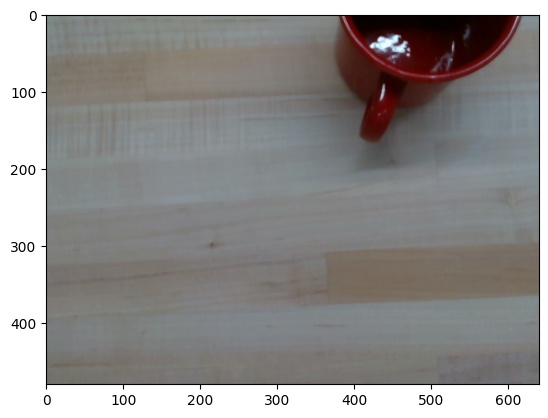

f_px : 392.99432373046875
The original Image size: 480x640
f_px: 392.99432373046875
Predicted Depth before reshape: torch.Size([1, 1, 1536, 1536])
Predicted Depth after reshape: torch.Size([1, 1, 480, 640]) using f_px: 392.99432373046875 and W: 640
Mask shape: (480, 640)


Org Depth shape: (480, 640)
Extracted Org Depth shape: (480, 640)
Pred Depth shape: (1, 480, 640)
Default Pred Depth shape: (1, 480, 640)
RMSE: 0.07859034879413701 , Default RMSE: 0.18858196538323646 , Extracted RMSE: 0.017134988641863816 , Extracted Default RMSE: 0.041695380945274266


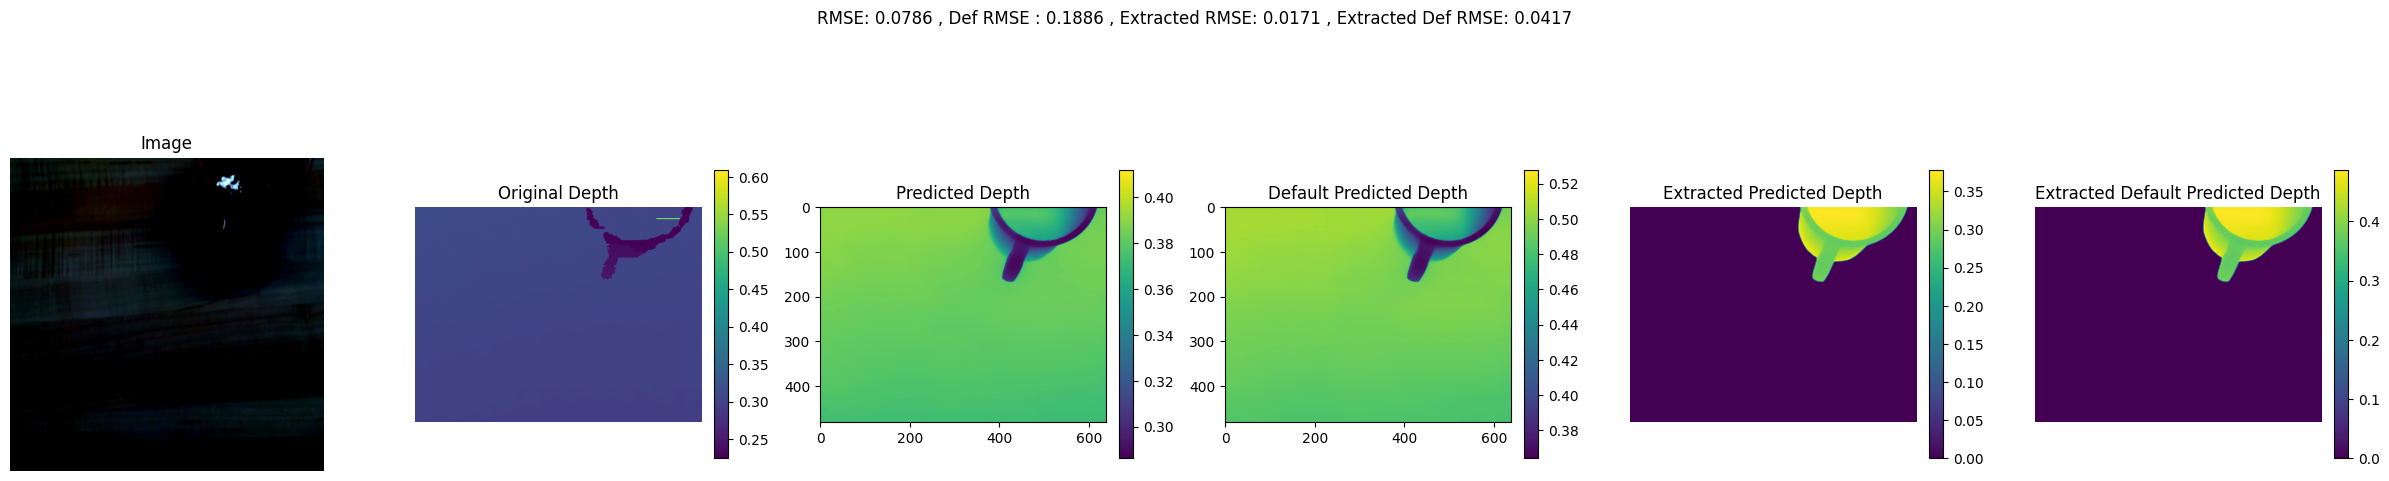

Original Depth Shape: (480, 640)
Predicted Depth Shape: (480, 640)
Default Predicted Depth Shape: (480, 640)
Extracted Predicted Depth Shape: (480, 640)
Extracted Default Predicted Depth Shape: (480, 640)
Mask shape: (480, 640)


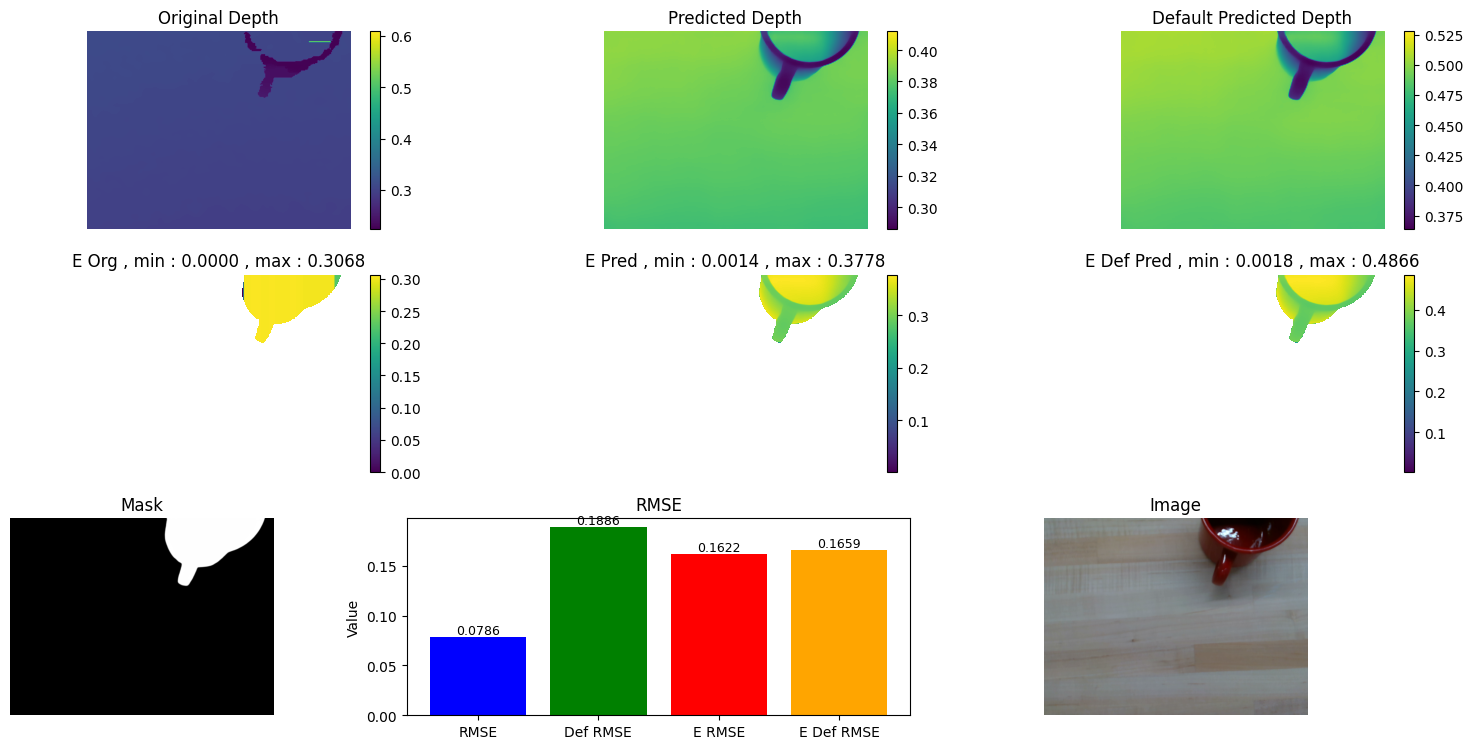

Mask shape: 307200 , min : 0.0 , max : 1.0
Org Depth : 0.2410 , Pred Depth : 0.2897 , Def Pred Depth : 0.3700 , E Org Depth : 0.3048 , E Pred Depth : 0.2897 , E Def Pred Depth : 0.3700


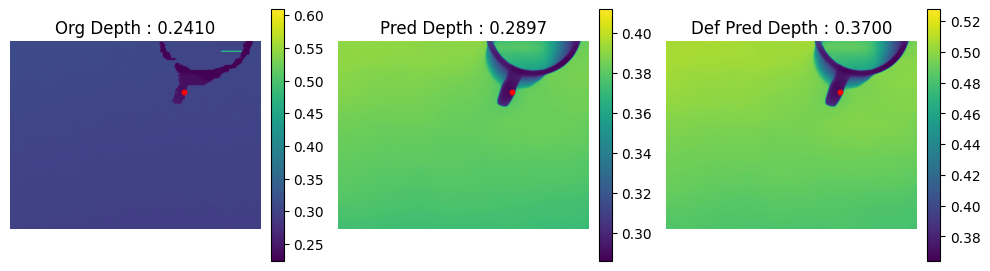

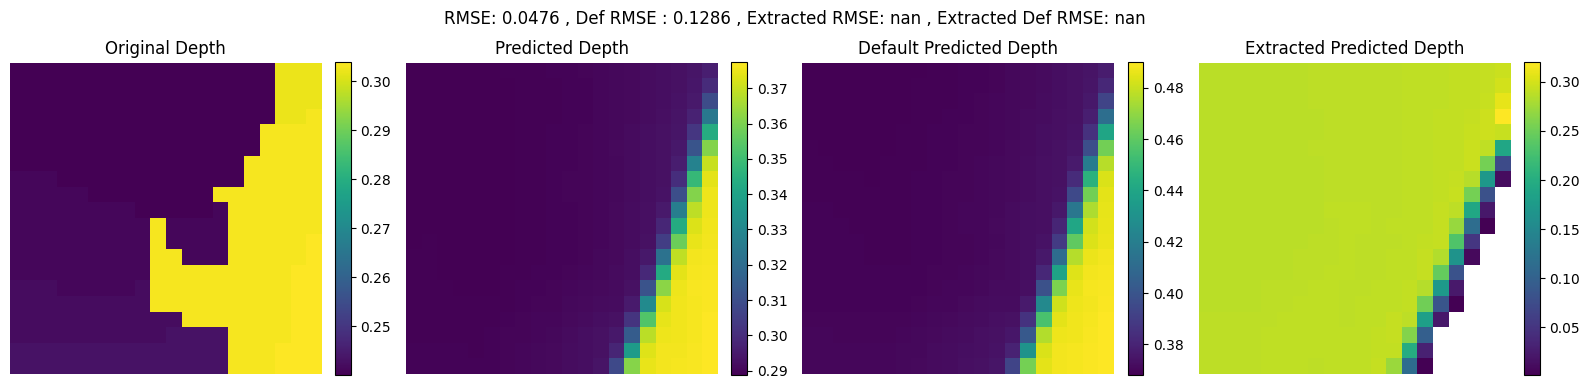

Org Depth : 0.2290 , Pred Depth : 0.3392 , Def Pred Depth : 0.4355 , E Org Depth : 0.3038 , E Pred Depth : 0.3392 , E Def Pred Depth : 0.4355


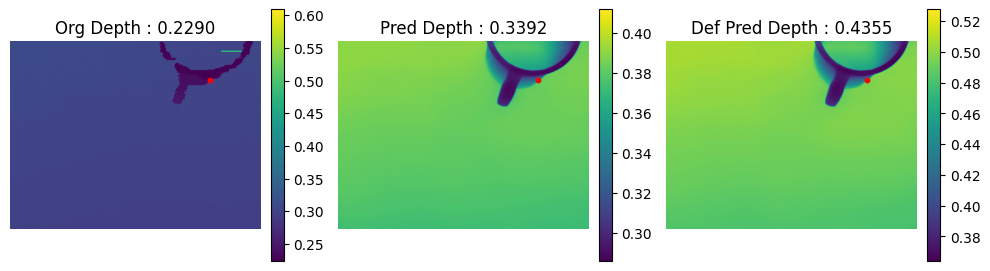

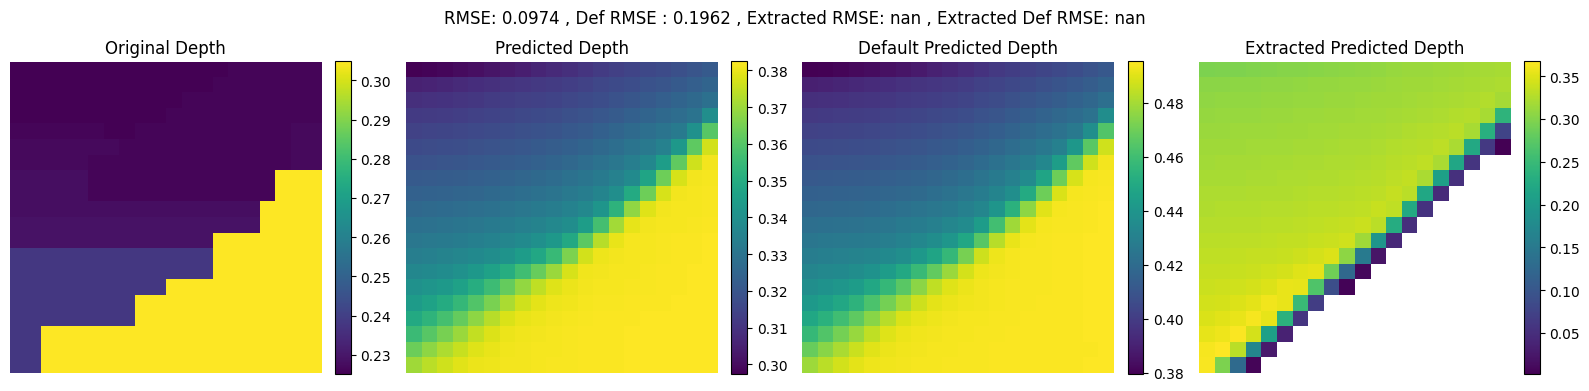

Org Depth : 0.2410 , Pred Depth : 0.2890 , Def Pred Depth : 0.3690 , E Org Depth : 0.3048 , E Pred Depth : 0.2890 , E Def Pred Depth : 0.3690


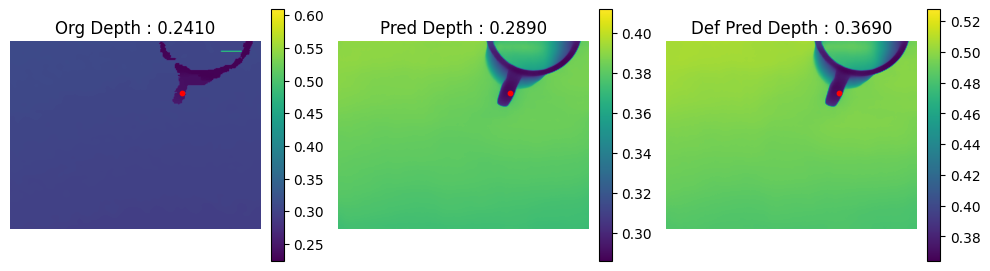

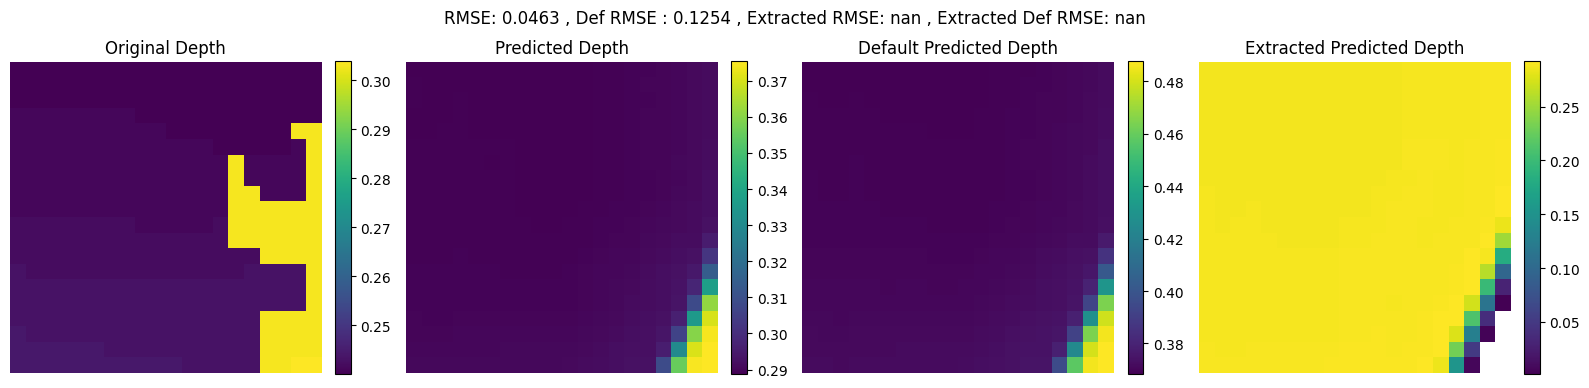

: 

In [ ]:
num = 1

test_images_dir = f'/home/badari/Thesis_Depth/Analysis/Test_Images/color_image_{num}.png'
org_depths_path = f'/home/badari/Thesis_Depth/Analysis/Test_Images/depth_data_{num}.npy'

# test_images_dir = '/home/badari/Thesis_Depth/Analysis/grasp1b_dataset_organized/val/images/scene_0090_0015.png'
# org_depths_path = '/home/badari/Thesis_Depth/Analysis/grasp1b_dataset_organized/val/depth/scene_0090_0015.png'

# test_images_dir = "/home/badari/Thesis_Depth/Analysis/YCB_Video/train/images/00001.png"
# org_depths_path = "/home/badari/Thesis_Depth/Analysis/YCB_Video/train/depth/00001.png"

img = Image.open(test_images_dir)

plt.imshow(img)
plt.show()

img = np.array(img)
H,W,_ = img.shape
F_PX = {'848':386.526 , '640':392.99432373046875 , '1280':583.5 , '1024':466.8 , '1536':700.37 , '2048':933.99}

# Got Good Results with 303 and with the original ones ( which is 392.99432373046875) Getting bad results

analyze(test_images_dir, org_depths_path , f_px=F_PX[str(W)])